In [93]:
# @title Setup
from google.cloud import bigquery
from google.colab import data_table
import bigframes.pandas as bpd
import numpy as np
import pandas as pd

project = 'flight-de-project' # Project ID inserted based on the query results selected to explore
location = 'US' # Location inserted based on the query results selected to explore
client = bigquery.Client(project=project, location=location)
data_table.enable_dataframe_formatter()

## Reference SQL syntax from the original job
Use the ```jobs.query```
[method](https://cloud.google.com/bigquery/docs/reference/rest/v2/jobs/query) to
return the SQL syntax from the job. This can be copied from the output cell
below to edit the query now or in the future. Alternatively, you can use
[this link](https://console.cloud.google.com/bigquery?j=flight-de-project:US:script_job_7e8365ded74241519815ca4b2042397b_0)
back to BigQuery to edit the query within the BigQuery user interface.

In [94]:
# Running this code will display the query used to generate your previous job

# job = client.get_job('script_job_7e8365ded74241519815ca4b2042397b_0') # Job ID inserted based on the query results selected to explore
# print(job.query)

# Result set loaded from BigQuery job as a DataFrame
Query results are referenced from the Job ID ran from BigQuery and the query
does not need to be re-run to explore results. The ```to_dataframe```
[method](https://googleapis.dev/python/bigquery/latest/generated/google.cloud.bigquery.job.QueryJob.html#google.cloud.bigquery.job.QueryJob.to_dataframe)
downloads the results to a Pandas DataFrame by using the BigQuery Storage API. The read_gbq_table [method](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.pandas#bigframes_pandas_read_gbq_function) turns a BigQuery table into the BigFrames DataFrame.

To edit query syntax, you can do so from the BigQuery SQL editor or in the
```Optional:``` sections below.

In [66]:
# Running this code will read results from your previous job

# job = client.get_job('script_job_7e8365ded74241519815ca4b2042397b_0') # Job ID inserted based on the query results selected to explore
# destination = job.destination

# # Load data from a BigQuery table using BigFrames DataFrames:
# bq_df = bpd.read_gbq(f"{destination.project}.{destination.dataset_id}.{destination.table_id}")
# bq_df

## Show descriptive statistics using describe()
Use the ```DataFrame.describe()```
[method](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.dataframe.DataFrame#bigframes_dataframe_DataFrame_describe)
to generate descriptive statistics. Descriptive statistics include those that
summarize the central tendency, dispersion and shape of a dataset’s
distribution, excluding ```NaN``` values. You may also use other Python methods
to interact with your data.

In [67]:
# Generate descriptive statistics.
# bq_df.describe()

In [68]:
# Convert BigQuery DataFrame to pandas DataFrame.
# pandas_df = bq_df.to_pandas()

In [95]:
%%bigquery locations_df
SELECT *
FROM `flight-de-project.flight_data.locations`;

Query is running:   0%|          |

Downloading:   0%|          |

In [115]:
%%bigquery transactions_df
SELECT *
FROM `flight-de-project.flight_data.transactions`;

Query is running:   0%|          |

Downloading:   0%|          |

In [97]:
row_count = len(locations_df)
print(f"Number of rows in locations_df: {row_count}")
print(type(locations_df))
row_count = len(transactions_df)
print(f"Number of rows in transactions_df: {row_count}")
print(type(transactions_df))


Number of rows in locations_df: 1774
<class 'pandas.core.frame.DataFrame'>
Number of rows in transactions_df: 55699
<class 'pandas.core.frame.DataFrame'>


In [116]:
locations_df = locations_df.dropna()
transactions_df = transactions_df.dropna()


In [98]:
row_count = len(locations_df)
print(f"Number of rows in locations_df: {row_count}")
print(type(locations_df))
row_count = len(transactions_df)
print(f"Number of rows in transactions_df: {row_count}")
print(type(transactions_df))

Number of rows in locations_df: 1774
<class 'pandas.core.frame.DataFrame'>
Number of rows in transactions_df: 55699
<class 'pandas.core.frame.DataFrame'>


In [99]:
locations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1774 entries, 0 to 1773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   AirportCode  1773 non-null   object
 1   CountryName  1773 non-null   object
 2   Region       1773 non-null   object
dtypes: object(3)
memory usage: 41.7+ KB


In [100]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55699 entries, 0 to 55698
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   UniqueId                53926 non-null  object
 1   TransactionDateUTC      53926 non-null  object
 2   Itinerary               53926 non-null  object
 3   OriginAirportCode       53926 non-null  object
 4   DestinationAirportCode  53926 non-null  object
 5   OneWayOrReturn          53926 non-null  object
 6   Segment                 55699 non-null  object
dtypes: object(7)
memory usage: 3.0+ MB


In [101]:
transactions_df.columns

Index(['UniqueId', 'TransactionDateUTC', 'Itinerary', 'OriginAirportCode',
       'DestinationAirportCode', 'OneWayOrReturn', 'Segment'],
      dtype='object')

In [33]:
print(type(transactions_df['Segment']))

<class 'pandas.core.series.Series'>


In [102]:
transactions_df.dtypes

,0
UniqueId,object
TransactionDateUTC,object
Itinerary,object
OriginAirportCode,object
DestinationAirportCode,object
OneWayOrReturn,object
Segment,object


In [103]:
transactions_df['Segment'].dtypes

dtype('O')

In [117]:
transactions_df = transactions_df.drop_duplicates(subset="UniqueId", keep="first")

In [104]:
row_count = len(transactions_df)
print(f"Number of rows in transactions_df: {row_count}")

Number of rows in transactions_df: 55699


### ***Requirement:*** From which country are most transactions originating? How many transactions is this?
*This query joins the transactions table with the locations table on OriginAirportCode to find the country with the highest transaction count.*

In [118]:
# Perform the join on the 'OriginAirportCode' and 'AirportCode'
merged_df = pd.merge(transactions_df, locations_df, left_on='OriginAirportCode', right_on='AirportCode', how='inner')

# Group by 'CountryName' and count the number of transactions
country_transactions = merged_df.groupby('CountryName').size().reset_index(name='NumTransactions')

# Sort by the number of transactions in descending order
country_transactions = country_transactions.sort_values(by='NumTransactions', ascending=False)

# Display the result
top_20_country_transactions = country_transactions.head(20)
first_row = top_20_country_transactions.head(1)

first_column_value =first_row.iloc[0]
print(first_column_value)

CountryName        Netherlands
NumTransactions           6644
Name: 125, dtype: object


<ipython-input-119-164c0f625794>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='CountryName', y='NumTransactions', data=top_20_country_transactions, palette='Blues_d')


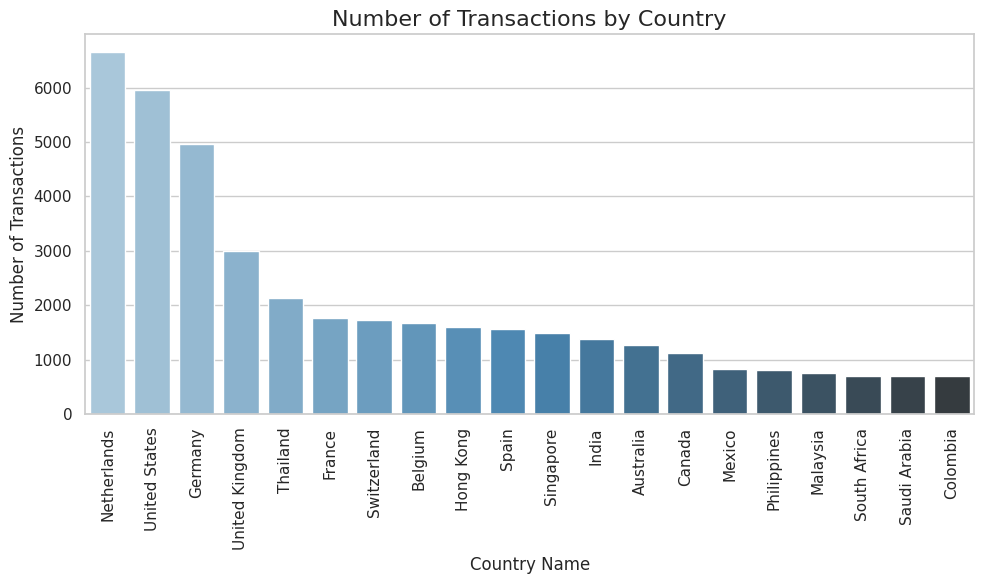

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a bar plot using seaborn
sns.barplot(x='CountryName', y='NumTransactions', data=top_20_country_transactions, palette='Blues_d')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Adding titles and labels
plt.title('Number of Transactions by Country', fontsize=16)
plt.xlabel('Country Name', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)

# Show the plot
plt.tight_layout()  # Adjusts the plot to fit in the figure area
plt.show()


### ***Requirement:*** What's the split between domestic vs international transactions?
*A domestic transaction is one where the origin and destination countries are the same. This query determines the counts of domestic and international transactions.*

In [120]:
import pandas as pd

# Assuming transactions_df and locations_df are already loaded

# Merge the transactions with the locations dataframe to get the country information for the origin airport
origin_df = pd.merge(transactions_df, locations_df[['AirportCode', 'CountryName']],
                     left_on='OriginAirportCode', right_on='AirportCode', suffixes=('_origin', '_origin_country'))

# Merge again to get the country information for the destination airport
destination_df = pd.merge(origin_df, locations_df[['AirportCode', 'CountryName']],
                           left_on='DestinationAirportCode', right_on='AirportCode', suffixes=('_origin', '_destination_country'))

# Check the column names to confirm the country columns
print(destination_df.columns)

# Rename columns to make sure they are clear and consistent
destination_df.rename(columns={'CountryName_origin_country': 'CountryName_origin',
                               'CountryName_destination_country': 'CountryName_destination'}, inplace=True)

# Classify as Domestic or International
destination_df['TransactionType'] = destination_df.apply(
    lambda x: 'Domestic' if x['CountryName_origin'] == x['CountryName_destination'] else 'International',
    axis=1)

# Count Domestic and International transactions
transaction_split = destination_df['TransactionType'].value_counts()

# Display the result
print(transaction_split)


Index(['UniqueId', 'TransactionDateUTC', 'Itinerary', 'OriginAirportCode',
       'DestinationAirportCode', 'OneWayOrReturn', 'Segment',
       'AirportCode_origin', 'CountryName_origin',
       'AirportCode_destination_country', 'CountryName_destination_country'],
      dtype='object')
TransactionType
International    48001
Domestic          5923
Name: count, dtype: int64


<ipython-input-121-fd9529d32900>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TransactionType', y='Count', data=split_df, palette='viridis')


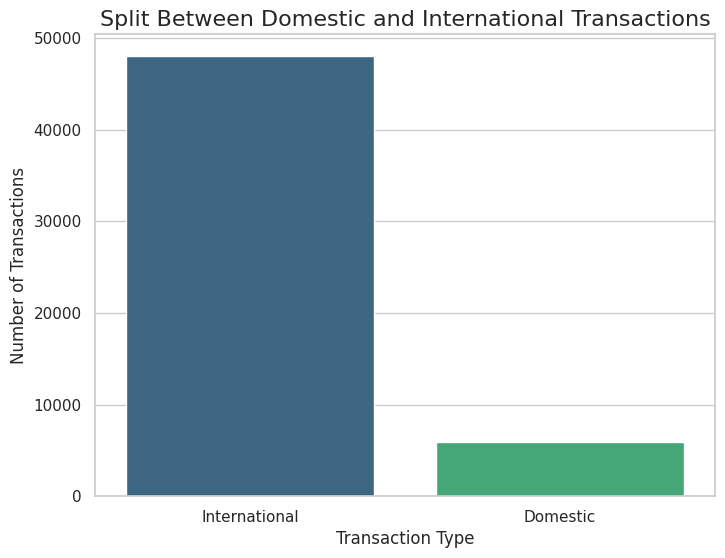

In [121]:

# Create a DataFrame for the split to make it easier for Seaborn to work with
split_df = transaction_split.reset_index()
split_df.columns = ['TransactionType', 'Count']

# Set up the Seaborn style and plot the barplot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a bar plot
sns.barplot(x='TransactionType', y='Count', data=split_df, palette='viridis')

# Add title and labels
plt.title('Split Between Domestic and International Transactions', fontsize=16)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)

# Show the plot
plt.show()


### ***Requirement:*** What's the distribution of number of segments included in transactions?
*Count the number of segments for each transaction by extracting the length of that array.*



                                             Segment  NumSegments
0  [{'DepartureAirportCode': 'LHR', 'ArrivalAirpo...            3
1  [{'DepartureAirportCode': 'CDG', 'ArrivalAirpo...            5
2  [{'DepartureAirportCode': 'IKT', 'ArrivalAirpo...            3
3  [{'DepartureAirportCode': 'MEL', 'ArrivalAirpo...            5
4  [{'DepartureAirportCode': 'GVA', 'ArrivalAirpo...            3


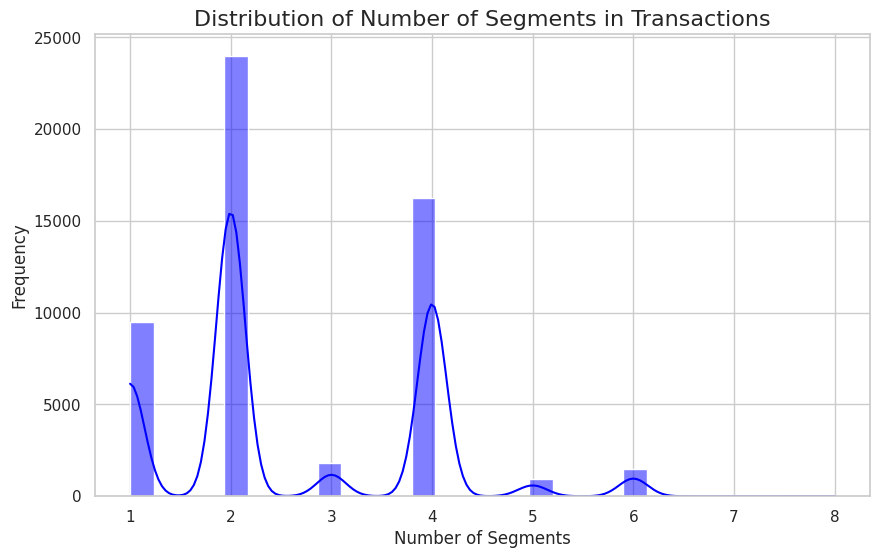

In [122]:
# Calculate the number of segments for each transaction by getting the length of the 'Segments' list
transactions_df['NumSegments'] = transactions_df['Segment'].apply(len)

# Check the first few rows to ensure the new 'NumSegments' column is correct
print(transactions_df[['Segment', 'NumSegments']].head())

# Set up the Seaborn style and plot the distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a histogram of the number of segments
sns.histplot(transactions_df['NumSegments'], kde=True, bins=30, color='blue')

# Add title and labels
plt.title('Distribution of Number of Segments in Transactions', fontsize=16)
plt.xlabel('Number of Segments', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Show the plot
plt.show()

## ***Direct vs. Connecting Flights***

In [123]:
# Create a new column 'FlightType' based on the length of 'Segments'
transactions_df['FlightType'] = transactions_df['Segment'].apply(lambda x: 'Direct' if len(x) == 1 else 'Connecting')

# Group by FlightType and count the number of flights
flight_type_counts = transactions_df.groupby('FlightType').size().reset_index(name='NumFlights')
print(flight_type_counts)


   FlightType  NumFlights
0  Connecting       44425
1      Direct        9501


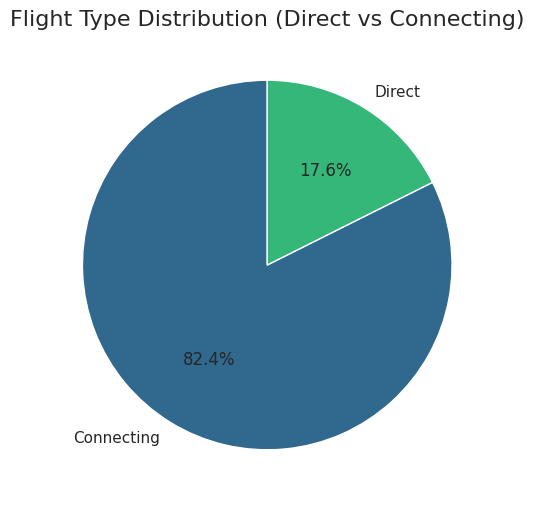

In [124]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Create a pie chart
plt.pie(flight_type_counts['NumFlights'], labels=flight_type_counts['FlightType'], autopct='%1.1f%%',
        colors=sns.color_palette('viridis', len(flight_type_counts)), startangle=90)

# Add title
plt.title('Flight Type Distribution (Direct vs Connecting)', fontsize=16)

# Show the plot
plt.show()


## ***Monthly Transaction Trends***

In [134]:
# Convert TransactionDateUTC to datetime format if not already
transactions_df['TransactionDateUTC'] = pd.to_datetime(transactions_df['TransactionDateUTC'], errors='coerce')

# Extract month from TransactionDateUTC
transactions_df['Months'] = transactions_df['TransactionDateUTC'].dt.month

# Group by month and count the number of transactions
monthly_trends = transactions_df.groupby('Months').size().reset_index(name='NumTransactions')

# Convert month numbers to month names
monthly_trends['Month'] = monthly_trends['Months'].apply(lambda x: pd.to_datetime(f'2021-{int(x)}-01').strftime('%B'))

# Ensure NumTransactions is of integer type (convert from float if necessary)
monthly_trends['NumTransactions'] = monthly_trends['NumTransactions'].astype(int)

# Print the result with month names
print(monthly_trends[['Month', 'NumTransactions']])


        Month  NumTransactions
0     January             5246
1    February             4970
2       March             5374
3       April             4695
4         May             5135
5        June             4084
6        July             4136
7      August             3968
8   September             4181
9     October             4196
10   November             3917
11   December             3450


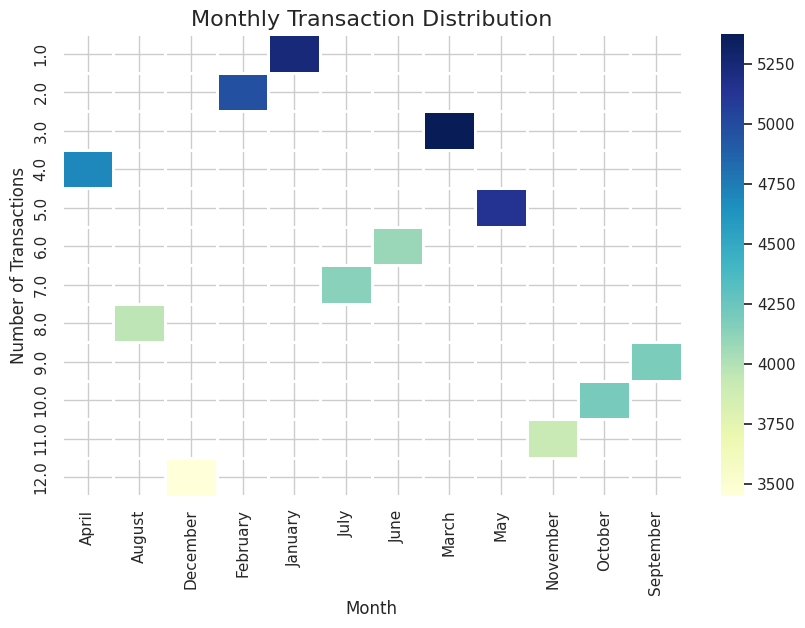

In [138]:
# Pivot the data for heatmap representation (create a 1D heatmap of months)
monthly_pivot = monthly_trends.pivot(index='Month', columns='Months', values='NumTransactions')

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(monthly_pivot.T, cmap='YlGnBu', fmt="f", cbar=True, linewidths=1)

# Add labels and title
plt.title('Monthly Transaction Distribution', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)

# Show the plot
plt.show()
